In [17]:
import glob
import os
import sys

import imageio
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils import data

# symlink D-DFFNet to ddffnet
sys.path.append("ddffnet")
from ddffnet.model.ours.PDNet_resnest import PDnet_ResNest_4F_SL_LA

In [18]:
class ImageData(data.Dataset):
	def __init__(self, img_root, transform):
		self.img_paths = sorted(glob.glob(os.path.join(img_root, '*')))
		self.transform = transform

	def __getitem__(self, item):
		img_path = self.img_paths[item]
		name = os.path.basename(img_path)

		image = Image.open(img_path).convert("RGB")
		x = TF.resize(image, [320, 320])
		image = np.array(image)

		if self.transform is None:
			x = image
		else:
			x = self.transform(x)
			
		return name, image, x

	def __len__(self):
		return len(self.img_paths)

In [19]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageData('./samples', transform)
data_loader = data.DataLoader(dataset=dataset, batch_size=1, shuffle=False, num_workers=2)

In [20]:
model = PDnet_ResNest_4F_SL_LA()

model:PDnet_ResNest_4F_SL_LA


In [21]:
!ls ddffnet/checkpoint

D-DFFNet.pth  DFFNet.pth  README.md


In [22]:
state = torch.load("ddffnet/checkpoint/D-DFFNet.pth")
model.load_state_dict(state)

<All keys matched successfully>

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

PDnet_ResNest_4F_SL_LA(
  (resnest): ResNest101(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

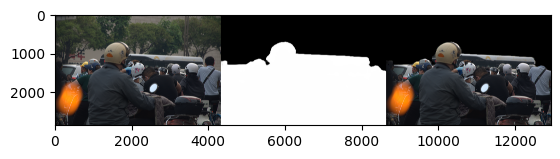

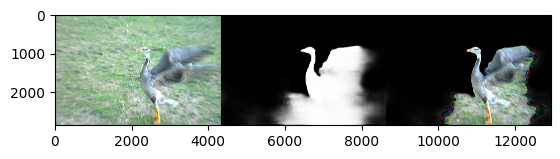

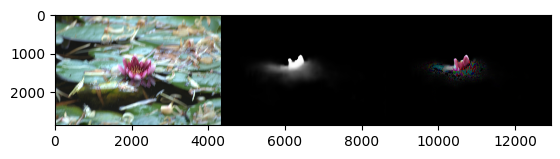

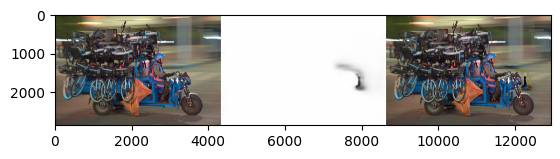

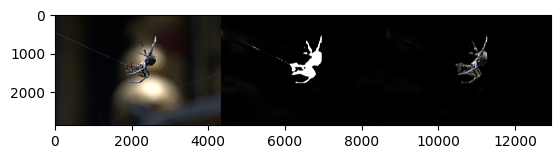

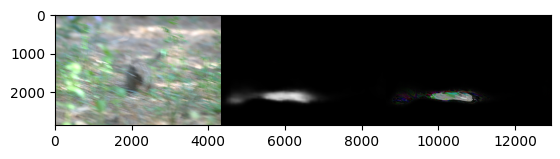

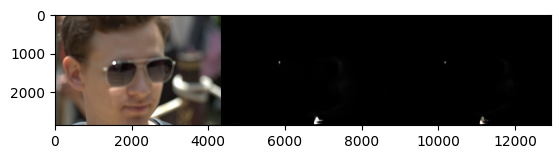

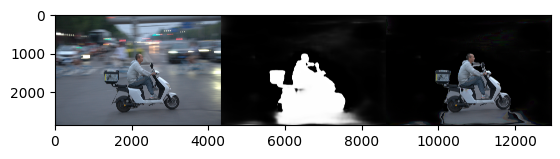

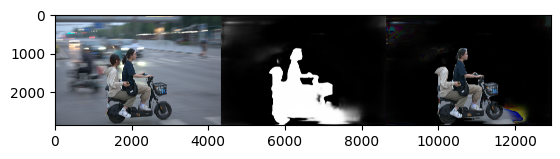

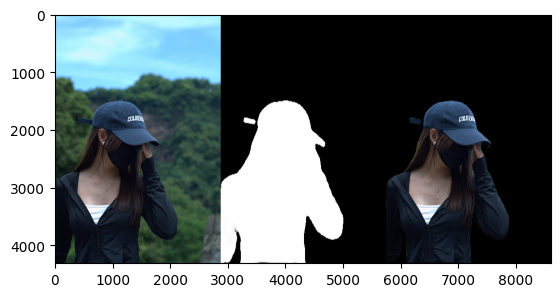

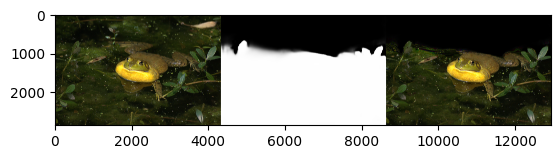

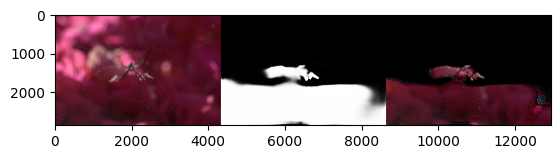

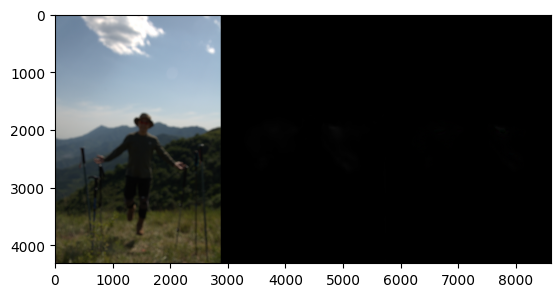

In [24]:
os.makedirs('results', exist_ok=True)

with torch.no_grad():
	for i, (name, image, x) in enumerate(data_loader):
		x = x.to(device)

		y, _, _ = model(x)
		y = torch.sigmoid(y)

		for filename, original, blur_map in zip(name, image, y):
			blur_map = torch.unsqueeze(blur_map, dim=0)
			blur_map = F.interpolate(blur_map, original.shape[:-1], mode='bilinear')
			blur_map = torch.squeeze(blur_map, dim=0).permute(1, 2, 0).cpu().numpy()

			blur_map = (blur_map * 255).astype(np.uint8)
			blur_map_rgb = np.dstack([blur_map] * 3)

			masked = original & blur_map_rgb 
			result = np.concatenate([original, blur_map_rgb, masked], axis=1)
			
			filename = os.path.splitext(filename)[0]
			imageio.imwrite(f'results/{filename}.jpg', result)
			
			fig, axs = plt.subplots(1, 1)
			axs.imshow(result)
			plt.show()